### Project 1: Accessibility Analysis of Tram Stops in Amsterdam Districts

In [6]:
# Load libraries
import geopandas as gpd
import fiona

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import folium

from rasterio import features
from rasterio.transform import from_origin
from rasterio.plot import show
import rasterstats as rs

In [7]:
# Load tram stops data from the city of Amsterdam

url = "https://maps.amsterdam.nl/open_geodata/geojson_lnglat.php?KAARTLAAG=TRAMMETRO_PUNTEN_2024&THEMA=trammetro"
tram = gpd.read_file(url)
tram.explore()

In [8]:
# Get the list of layers inside the geopackage file
layers = fiona.listlayers("data/Amsterdam_BAG.gpkg")
print(layers)

# Select the layer "Wijken" (= districts)
districts = gpd.read_file("data/Amsterdam_BAG.gpkg", layer="Wijken")
districts.explore()

['Pand', 'Verblijfsobject', 'Wijken']


In [9]:
# Check the CRS of the layers
print(tram.crs)
print(districts.crs)

EPSG:4326
EPSG:28992


In [10]:
# Reproject the tram stops to the same CRS as the districts
tram = tram.to_crs(districts.crs)

In [13]:
# Generate a 500-meter buffer around tram stops
buffers_gdf = tram.copy()
buffers_gdf["geometry"] = tram.geometry.buffer(500)
buffers_gdf.explore()

In [14]:
# Dissolve overlapping buffers to avoid double-counting
buffers_gdf["buffers"] = 0
dissolved_buffers_gdf = buffers_gdf.dissolve(by="buffers")
dissolved_buffers_gdf.explore()

In [15]:
# Perform geometric intersection between districts and dissolved buffers
intersection_gdf = gpd.overlay(districts, dissolved_buffers_gdf, how="intersection")
intersection_gdf.explore()

In [16]:
# Calculate area of each intersection
intersection_gdf["area_covered"] = intersection_gdf.area

# Group by district ID and sum the covered areas
area_covered_by_district = (
    intersection_gdf.groupby("Buurtcombinatie")["area_covered"].sum().reset_index()
)

# Merge the covered area data back to the original district data
districts = districts.merge(area_covered_by_district, on="Buurtcombinatie", how="left")

# Replace NaN values with 0 (for districts with no tram stop coverage)
districts["area_covered"] = districts["area_covered"].fillna(0)

# Calculate total area of each district
districts["total_area"] = districts.area

# Calculate area not covered by tram stop buffers, also calculate the proportion of this area
districts["area_not_covered"] = districts["total_area"] - districts["area_covered"]
districts["proport_not_covered"] = districts["area_not_covered"]/districts["total_area"]

# Display the results
print(districts[["Buurtcombinatie", "total_area", "area_covered", "area_not_covered"]])

            Buurtcombinatie    total_area  area_covered  area_not_covered
0     Burgwallen-Oude Zijde  4.047169e+05  4.047169e+05      0.000000e+00
1   Burgwallen-Nieuwe Zijde  7.283908e+05  7.261132e+05      2.277636e+03
2       Grachtengordel-West  5.690387e+05  5.552258e+05      1.381295e+04
3       Grachtengordel-Zuid  6.418352e+05  6.418352e+05      2.328306e-10
4        Nieuwmarkt/Lastage  1.066759e+06  9.977749e+05      6.898436e+04
..                      ...           ...           ...               ...
94     Bijlmer Oost (E,G,K)  4.075905e+06  1.710287e+06      2.365617e+06
95               Nellestein  2.948612e+06  5.315780e+05      2.417034e+06
96   Holendrecht/Reigersbos  2.712447e+06  1.218849e+06      1.493598e+06
97                     Gein  1.921408e+06  7.811475e+05      1.140261e+06
98                 Driemond  2.023220e+06  0.000000e+00      2.023220e+06

[99 rows x 4 columns]


In [17]:
# Summarize the total area, covered area, and not covered area for all districts

m_km = 10000000
total_area_tram = districts["total_area"].sum() / m_km
total_covered_area_tram = districts["area_covered"].sum() / m_km
total_not_covered_area_tram = districts["area_not_covered"].sum() / m_km

print("\nSummary for All Districts:")
print(f"Total area: {total_area_tram:.2f} km²")
print(f"Covered area: {total_covered_area_tram:.2f} km²")
print(f"Not covered area: {total_not_covered_area_tram:.2f} km²")


Summary for All Districts:
Total area: 21.95 km²
Covered area: 6.66 km²
Not covered area: 15.29 km²


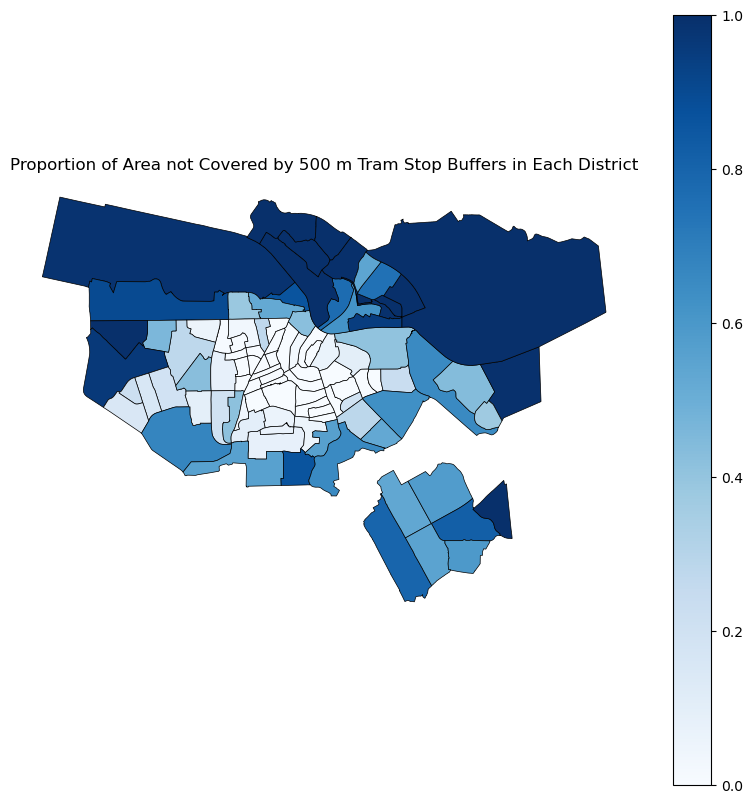

In [21]:
# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
districts.plot(
    ax = ax,
    column = "proport_not_covered",
    legend = True,
    cmap = "Blues",
    edgecolor = "black",
    linewidth = 0.5,
)
plt.title("Proportion of Area not Covered by 500 m Tram Stop Buffers in Each District")
ax.axis("off")
plt.show()